In [ ]:
import torch

debug =  False
monitoring = False # set to true if you want to monitor during the training with the wandb librairie
word_level = True #if word level is set to True the model will predict word by word , else character by character
cfg = {
    'description' :"entrainement classique",
    'batch_size': 64,
    'block_size': 128,
    'max_iters': 3000,
    'eval_interval': 200,
    'learning_rate': 1e-4,
    'device': 'cuda' if torch.cuda.is_available() else 'cpu',
    'eval_iters': 200,
    'n_embed': 256, #should be divisible by num_head
    'num_heads': 8,
    'num_blocks': 6,
    'dropout': 0.4,
    'fraction_training_data': 0.9,
    'word_level' : word_level
}

torch.manual_seed(1337)
print("GPU : ",  torch.cuda.is_available())


GPU :  True


In [ ]:
# download libriairies, code and data that we need

if monitoring : # install the librairie wandb to monitor the loss etc..
  !pip install wandb

#install gradio
!pip install gradio
#my files with classes and functions
!wget https://raw.githubusercontent.com/Luckyluuuc/GPTmodel/main/src/model.py
!wget https://raw.githubusercontent.com/Luckyluuuc/GPTmodel/main/src/utils.py
#Training corpus:
!wget https://raw.githubusercontent.com/Luckyluuuc/GPTmodel/main/data/harry-potter-7.txt

In [ ]:
#import the librairies

#pytorch:
# torch already imported above
import torch.nn as nn
from torch.nn import functional as F
import torch.optim as optim


#to monitor :
if monitoring : import wandb
from tqdm.auto import tqdm # for the progress bar
import matplotlib.pyplot as plt


# to have a nice interface to generate text
import gradio as gr


# my files
from model import GPTmodel
from utils import *

In [ ]:
if monitoring: wandb.init(project='GPT Harry potter word level', config=cfg)

### Download and prepare the data


In [ ]:
with open('/content/harry-potter-7.txt', 'r', encoding='utf-8') as f: # choose the training corpus here
    text = f.read()
print("length of dataset in characters: ", len(text))
if len(text) < 1000000 : print("the length of the corpus is less than 1M characters it might be to small")
print( "\n\n An extract of the data : \n\n\n " ,"\033[31m", text[1000:2000])

if word_level :
  text = tokenize_text(text)

print('\033[0m', "\n\n\n", "An extract of 20 tokens",list(text[1000:1020]))

length of dataset in characters:  1346804


 An extract of the data : 


    ? demanda le plus grand des deux.

— Excellentes, répondit Severus Rogue.

Le chemin était bordé à gauche par des mûriers sauvages aux tiges basses et, à droite, par une haute
haie soigneusement taillée. Les longues capes des deux hommes ondulaient autour de leurs chevilles
au rythme de leurs pas.

— J’ai cru que j’allais arriver en retard, dit Yaxley, dont le visage taillé à coups de serpe apparaissait
et disparaissait sous les branches des arbres qui masquaient par endroits la lueur de la lune. C’était un
peu plus difficile que je ne l’avais pensé. Mais j’espère qu’il sera satisfait. Tu as l’air sûr de toi. Tu
penses que tu seras bien reçu ?

Rogue acquiesça d’un signe de tête mais ne donna pas de détails. Ils tournèrent à droite, dans une
large allée qui s’éloignait du chemin. La haute haie suivit la même courbe, s’étendant au loin, par-
delà l’impressionnant portail de fer forgé qui barrait la route des de

### Create a map between characters and integers
**Objective**: associate to each characters to an integers using dictionnaries

In [ ]:
vocab_size, stoi, itos = mapp(text) #we assign to each token an integers and itos and stoi are the dictionnaries that allow to pass from one to the other and vice versa
data_tok = encode(text, stoi) # we tranform our text into a list of integers thanks to the dictionnary stoi

if debug:
  print("vocab_size :", vocab_size)
  print("stoi :", stoi)
  print("itos :", itos)
  print("First 100 token of the encoded text : ", data_tok[:100])

#splitting the data -> one for training and one for evaluating (cross_validation)

train_set, validation_set = splitting_data(cfg.get('fraction_training_data'), data_tok)

if debug:
  print("")
  print("train set -> length :", len(train_set))
  print(train_set[:50])
  print("validation set -> length :", len(validation_set))
  print(validation_set[:50])





### GPT Model

In [ ]:
m = GPTmodel(cfg, vocab_size)
m = m.to(cfg.get('device'))

#weight manager to save weigths
w = WeightManager("/content/weights.pth") #be careful to choose the right path
# to test the model before training maybe we could make all of this in the generate function
idx = torch.zeros((1,1), dtype=torch.long, device=cfg.get('device'))
print(decode(m.generate(idx, max_new_tok=100)[0].tolist(), itos))


touffuesrejetteinscritprononçait26ENQUÊTEcomportémonteessaierontmatièresentirmentonmanquantdébattrechuchotaapparutconsolermarchenthabiterasbraiséloupelégèrementsortVOTREsouciaitrépandantLorsfraisescapturésattendchansonvitesseabattaitbrûlaampleraisonnablementenvoyeraffirméattendronsFlagrancesemainerêvesépouseacharnementémergeaBarrrnyenleverinvinciblesVraimentdéfenseabattudeboutassistaitpossibilitéRavitraînanteWaoochaloupéeeffleurermarionnetteterritoiresapprochaitsuivierevêchesoulevaitbénéficionsfixéaffecterhurléfonctionsauceépargnerreviensAujourdagenouillerévidentfourprovoquéeélémentperceptiblesferméesbusteproblèmesmatérialisacombattonsdisposéesseuilduretésoutenucontrôlerEncorevoulonsamplifiarudimentairesentourégarantithabiterépugnaitinstantanément


  0%|          | 0/3000 [00:00<?, ?it/s]

step 0/3000: train loss 9.7041, val loss 9.7015  Saving weights
step 200/3000: train loss 3.6092, val loss 3.6246  Saving weights
step 400/3000: train loss 3.4603, val loss 3.4894  Saving weights
step 600/3000: train loss 3.4055, val loss 3.4553  Saving weights
step 800/3000: train loss 3.3410, val loss 3.4002  Saving weights
step 1000/3000: train loss 3.2339, val loss 3.2981  Saving weights
step 1200/3000: train loss 3.1297, val loss 3.2081  Saving weights
step 1400/3000: train loss 2.9990, val loss 3.0903  Saving weights
step 1600/3000: train loss 2.8941, val loss 3.0061  Saving weights
step 1800/3000: train loss 2.8091, val loss 2.9389  Saving weights
step 2000/3000: train loss 2.7429, val loss 2.8859  Saving weights
step 2200/3000: train loss 2.6838, val loss 2.8449  Saving weights
step 2400/3000: train loss 2.6342, val loss 2.8138  Saving weights
step 2600/3000: train loss 2.5931, val loss 2.7847  Saving weights
step 2800/3000: train loss 2.5536, val loss 2.7580  Saving weights
st

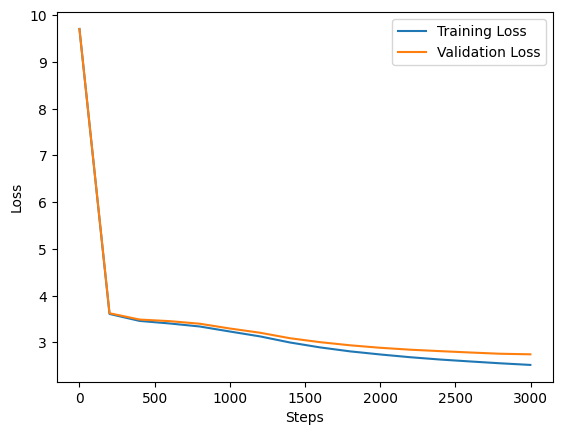

In [8]:
#train the model
#create the optimizer
optimizer = torch.optim.AdamW(m.parameters(), lr=cfg.get("learning_rate"))


#train
def training(m,w, max_iters, eval_interval, eval_iters, block_size, batch_size, device, train_set, validation_set ):

  best_loss = 100
  progress_bar = tqdm(range(max_iters)) # instanciation of the pogress bar
  train_losses = []  # List to store training losses
  val_losses = []  # List to store validation losses
  step_values = []  # List to store step values


  for step in range (max_iters):
    xb, yb = get_batch("train", block_size, batch_size , device, train_set, validation_set)

    #evaluate the loss
    if step % eval_interval == 0 or step==max_iters-1 :
      losses = estimate_loss(m, eval_iters, train_set, validation_set, block_size, batch_size, device)
      msg = ""
      if losses['eval'] < best_loss:
        best_loss = losses['eval']
        w.save_weights(m)
        msg = "Saving weights"
      print(f"step {step}/{max_iters}: train loss {losses['train']:.4f}, val loss {losses['eval']:.4f} ", msg)
      if monitoring : wandb.log({'train_loss': losses['train'], 'eval_loss': losses['eval'], 'step': step})

      # Append losses to the lists
      train_losses.append(losses['train'])
      val_losses.append(losses['eval'])
      step_values.append(step)


    logits, loss = m(xb, yb)

    optimizer.zero_grad(set_to_none=True)
    loss.backward()
    optimizer.step()
    progress_bar.update(1) #step by one the progress bar

  print("\n","End of training")

  # Plot the losses
  plt.plot(step_values, train_losses, label='Training Loss')
  plt.plot(step_values, val_losses, label='Validation Loss')
  plt.xlabel('Steps')
  plt.ylabel('Loss')
  plt.legend()
  plt.show()

training(m, w,  cfg.get('max_iters'), cfg.get('eval_interval'), cfg.get('eval_iters') , cfg.get('block_size'), cfg.get('batch_size'), cfg.get('device'), train_set, validation_set)



In [10]:
w.load_weights(m) #to load the state of the weight where the lost were the lower or if you have weights from a previous training
m.eval()

# generate with some context
def completion(context="\n", length=100):
  if word_level:
    context = tokenize_text(context)
  indices = [encode(context, stoi)]
  print(indices)
  idx = torch.tensor(indices, dtype=torch.long, device=cfg.get('device'))
  output = m.generate(idx, max_new_tok=100)
  return decode(m.generate(output, max_new_tok=length)[0].tolist(), itos)

with gr.Blocks() as demo:
    default_text = "\n"
    textbox = gr.Textbox(placeholder="Type here...", lines=4, value=default_text)
    btn = gr.Button("Autocomplete")
    slider = gr.Slider(label="length", minimum=100, maximum=4000)

    # define what will run when the button is clicked, here the textbox is used as both an input and an output
    btn.click(fn=completion, inputs= [textbox,  slider], outputs=textbox, queue=False)

demo.launch()


Setting queue=True in a Colab notebook requires sharing enabled. Setting `share=True` (you can turn this off by setting `share=False` in `launch()` explicitly).

Colab notebook detected. To show errors in colab notebook, set debug=True in launch()
Running on public URL: https://e83cbf1a2f22972e87.gradio.live

This share link expires in 72 hours. For free permanent hosting and GPU upgrades, run `gradio deploy` from Terminal to deploy to Spaces (https://huggingface.co/spaces)
